# Tomato Regression Model with SARIMA
By Menard Gymer Rivera

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tomato_UN = pd.read_excel('./data/tomato_UN.xlsx')

In [3]:
Tomato_DA = pd.read_excel('./data/tomato_DA.xlsx')

In [4]:
Tomato_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,114,Tomatoes - Retail,5,KG,1,2008,55.27
1,114,Tomatoes - Retail,5,KG,1,2008,39.48
2,114,Tomatoes - Retail,5,KG,1,2008,34.39
3,114,Tomatoes - Retail,5,KG,1,2008,32.45
4,114,Tomatoes - Retail,5,KG,1,2008,40.55
...,...,...,...,...,...,...,...
2667,114,Tomatoes - Retail,5,KG,6,2021,40.63
2668,114,Tomatoes - Retail,5,KG,6,2021,42.50
2669,114,Tomatoes - Retail,5,KG,6,2021,37.50
2670,114,Tomatoes - Retail,5,KG,6,2021,54.38


In [5]:
Tomato_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Tomatoes - Retail,NaN,KG,1,2022,60.21
1,NaN,Tomatoes - Retail,NaN,KG,2,2022,54.45
2,NaN,Tomatoes - Retail,NaN,KG,3,2022,80.74
3,NaN,Tomatoes - Retail,NaN,KG,4,2022,108.35
4,NaN,Tomatoes - Retail,NaN,KG,5,2022,91.70


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tomato_UN['date'] = pd.to_datetime(
    Tomato_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tomato_UN = Tomato_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tomato_UN.head()

,mp_price,date
0,55.27,2008-01-15
1,39.48,2008-01-15
2,34.39,2008-01-15
3,32.45,2008-01-15
4,40.55,2008-01-15


### DA Bantay Presyo

In [9]:
Tomato_DA['date'] = pd.to_datetime(
    Tomato_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tomato_DA = Tomato_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tomato_DA.head()

,mp_price,date
0,60.21,2022-01-15
1,54.45,2022-02-15
2,80.74,2022-03-15
3,108.35,2022-04-15
4,91.70,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tomato = pd.concat([Tomato_DA, Tomato_UN])

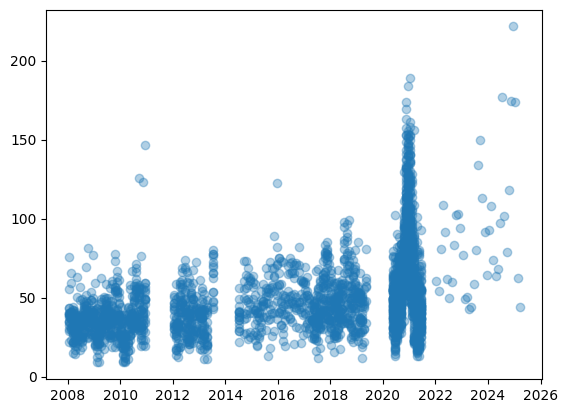

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tomato['date'], Tomato['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tomato = Tomato.set_index('date')

In [17]:
# Aggregate samples to mean
Tomato = Tomato.resample('MS').mean()

In [18]:
Tomato['mp_price'] = Tomato['mp_price'].interpolate(method='linear')

In [19]:
print("🕓 Index Range:")
print(f"Start: {Tomato.index.min()}")
print(f"End:   {Tomato.index.max()}")
print(f"Index type: {type(Tomato.index)}\n")

🕓 Index Range:
Start: 2008-01-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [20]:
start_date = datetime(2000,1,1)
end_date = datetime(2026,1,1)
lim_Tomato = Tomato[start_date:end_date]

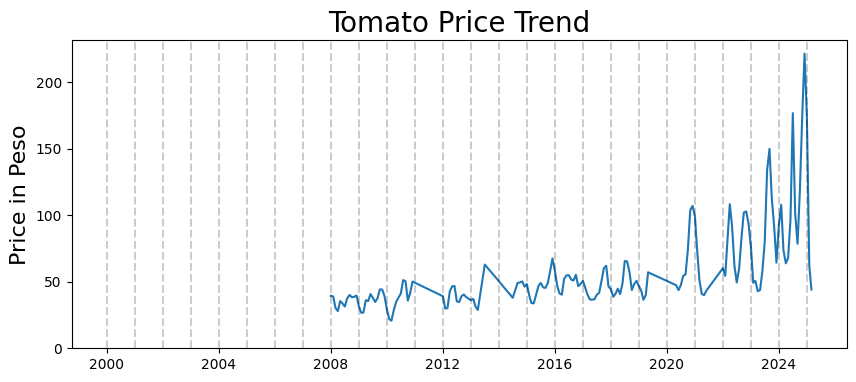

In [21]:
plt.figure(figsize=(10,4))
plt.plot(lim_Tomato)
plt.title('Tomato Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [22]:
first_diff = lim_Tomato.diff()[1:]

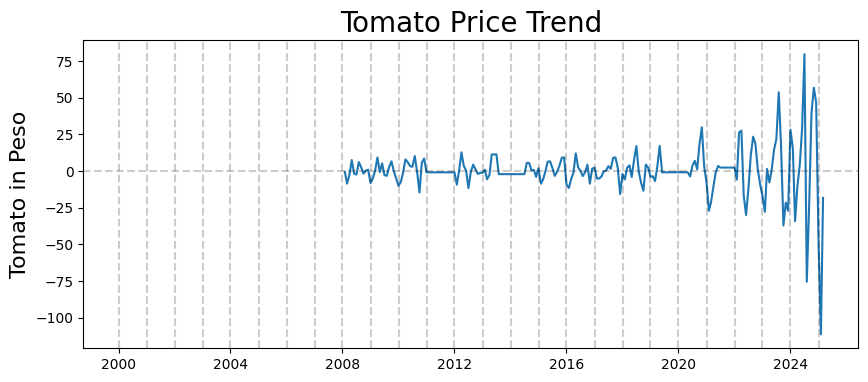

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tomato Price Trend', fontsize=20)
plt.ylabel('Tomato in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [24]:
from statsmodels.tsa.stattools import acf

<BarContainer object of 25 artists>

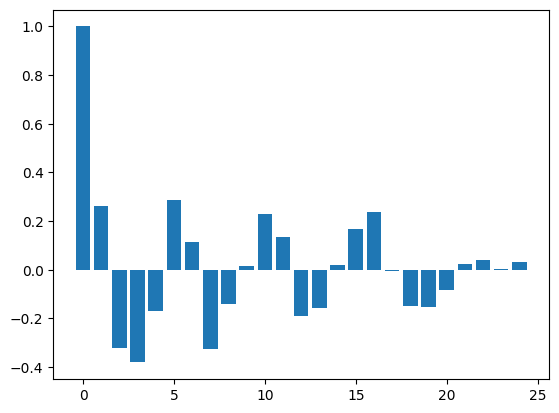

In [25]:


num_lags = 25
acf_vals = acf(first_diff, nlags=num_lags-1)
plt.bar(range(num_lags), acf_vals)


### Based on ACF, we should start with a seasonal MA process

## PACF

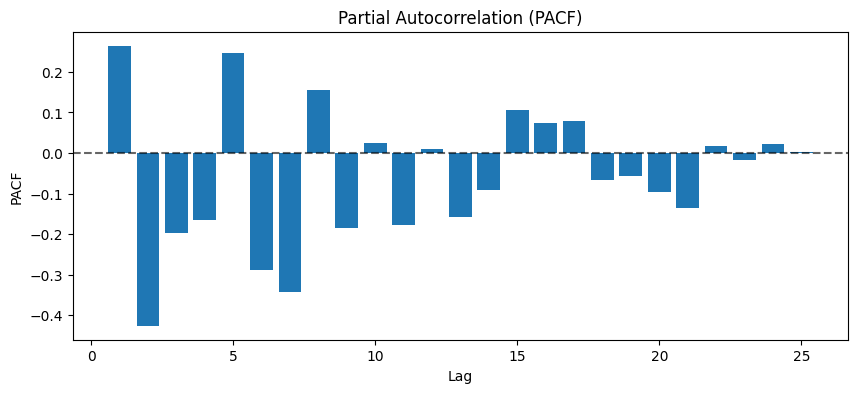

In [26]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

# Create first-differenced time series
ts = Tomato['mp_price']
first_diff = ts.diff().dropna()

# Calculate PACF values up to the specified number of lags
num_lags = 25
pacf_vals = pacf(first_diff, nlags=num_lags)

# Plot PACF values, excluding lag 0
plt.figure(figsize=(10, 4))
plt.bar(range(1, num_lags + 1), pacf_vals[1:num_lags + 1])
plt.title('Partial Autocorrelation (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.axhline(0, color='black', linestyle='--', alpha=0.6)
plt.show()


### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [27]:
from datetime import timedelta

In [28]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_Tomato[:train_end]
test_data = lim_Tomato[train_end + timedelta(days=1):test_end]

In [29]:
Tomato.describe()

,mp_price
count,207.000000
mean,54.465291
std,27.492167
min,20.740000
25%,40.053312
50%,47.367888
75%,55.978984
max,221.570000


## Fit the SARIMA Model

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [32]:
from time import time

In [33]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.10120677947998047


In [34]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                  201
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -794.932
Date:                              Tue, 20 May 2025   AIC                           1595.864
Time:                                      12:15:50   BIC                           1605.759
Sample:                                  01-01-2008   HQIC                          1599.868
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0903      0.376      0.240      0.810      -0.646       0.827
ma.S.L12      -0.35

In [35]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    117.90
2024-11-01    174.67
2024-12-01    221.57
2025-01-01    173.53
2025-02-01     62.36


In [36]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [37]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [38]:
predictions

date
2024-10-01     86.252985
2024-11-01     91.350773
2024-12-01     99.087093
2025-01-01     93.323687
2025-02-01     92.359212
2025-03-01    100.506656
Freq: MS, Name: predicted_mean, dtype: float64

In [39]:
residuals

date
2024-10-01     31.647015
2024-11-01     83.319227
2024-12-01    122.482907
2025-01-01     80.206313
2025-02-01    -29.999212
2025-03-01    -56.366656
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

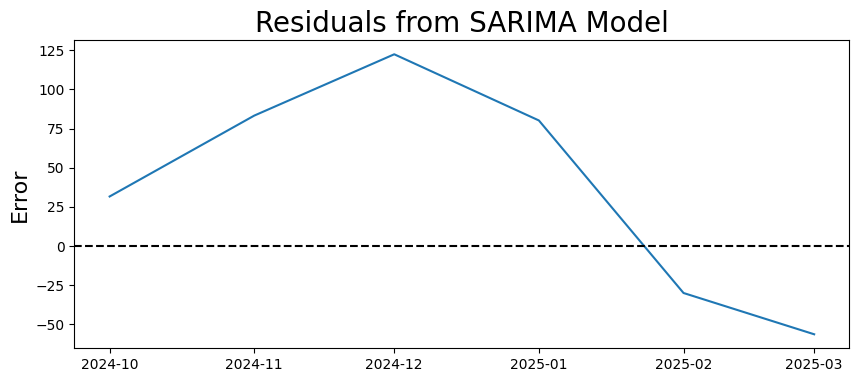

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

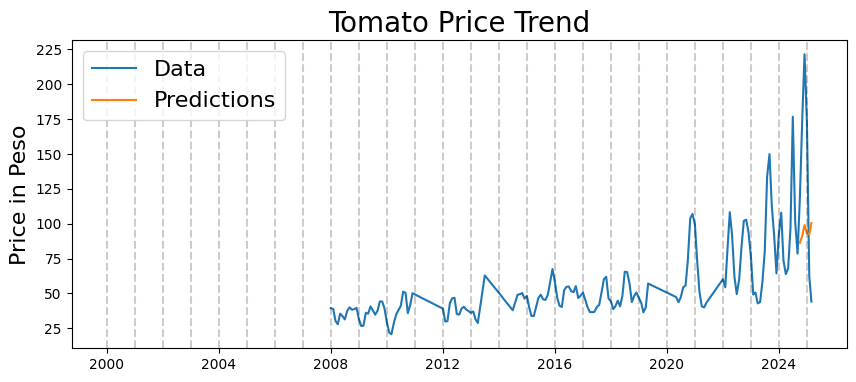

In [41]:
plt.figure(figsize=(10,4))

plt.plot(lim_Tomato)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tomato Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [42]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_Tomato[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipykernel_71474/2177266668.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_71474/2177266668.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_71474/2177266668.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_71474/2177266668.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_71474/2177266668.py:8: FutureWarning: Calling float on a single element Series is deprecated and will

In [43]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

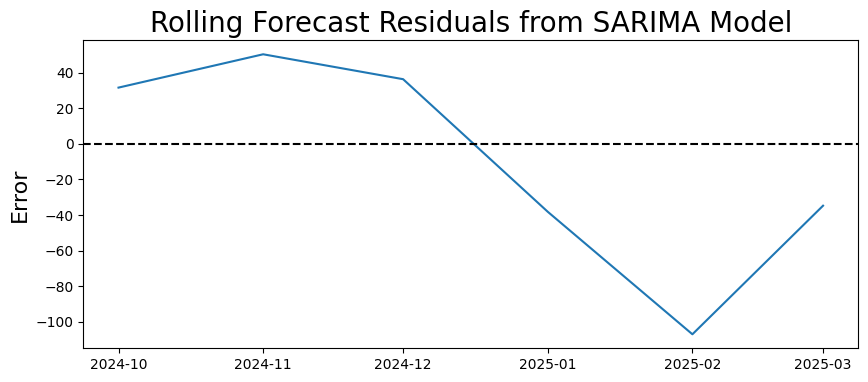

In [44]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

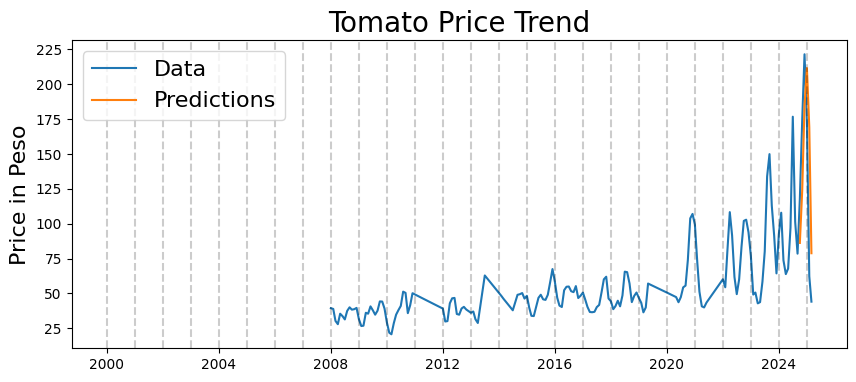

In [45]:
plt.figure(figsize=(10,4))

plt.plot(lim_Tomato)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tomato Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [46]:
import numpy as np

In [47]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.574


In [48]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 56.23919284050747


## Future Predictions (2025)